## Importing the data for model training

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # AlexNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder('./data/ImgData/IotNetworkIntrusionDataset/Big', transform=transform)

# Perform train-test-valid split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# test_size = int(0.1 * len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [2]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 625783
    Root location: ./data/ImgData/IotNetworkIntrusionDataset/Big
    StandardTransform
Transform: Compose(
               Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [3]:
print(train_loader)

In [4]:
import matplotlib.pyplot as plt

In [5]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 227, 227])
Labels batch shape: torch.Size([32])


### Sample Train Data

C:\Users\aousa\AppData\Local\Temp\ipykernel_14968\3141201390.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3641.)
  img_data.append(img.T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


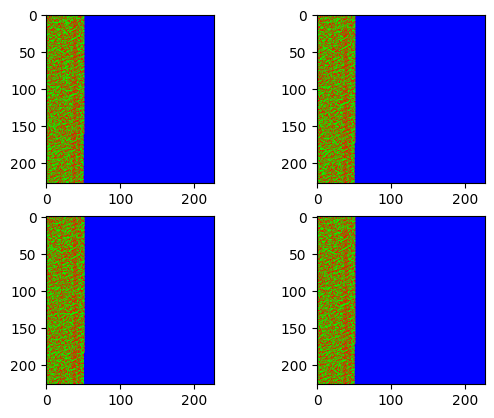

In [6]:
display_img_no = 4
# define 2x2 graphics 
f, axarr = plt.subplots(2, 2)
img_data = []
for i in range(display_img_no):
    img = train_features[i].squeeze()
    label = train_labels[i]
    img_data.append(img.T)
    # plt.imshow(img.T)
    # plt.show()
axarr[0,0].imshow(img_data[0])
axarr[0,1].imshow(img_data[1])
axarr[1,0].imshow(img_data[2])
axarr[1,1].imshow(img_data[3])

## Implementing pre-trained model 

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Load pre-trained AlexNet Model

In [8]:
import torchvision.models as models
# Load pre-trained AlexNet model
alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

### Shift to using CUDA GPU

In [9]:
if torch.cuda.is_available():
    alexnet.cuda()

### Modify Output Layer

In [10]:
import torch.nn as nn

# Modify output layer
num_classes = 2  # Number of classes in your dataset
alexnet.classifier[6] = nn.Linear(4096, num_classes)

### Define loss function and Optimizer

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

### Trace losses for each epochs

In [12]:
# To keep track of loss
train_losses = []
accuracy_losses = []

### Train the model

In [13]:
num_epochs = 5  # Choose number of epochs
if torch.cuda.is_available():
    alexnet.cuda()
    
for epoch in range(num_epochs):
    # Training
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = alexnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    train_losses.append(train_loss)

    # save model on each epochs
    torch.save(alexnet, f'partial_alexnet_e{epoch}.pt')
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.0030
Epoch [2/5], Loss: 0.0011
Epoch [3/5], Loss: 0.0490
Epoch [4/5], Loss: 0.0130
Epoch [5/5], Loss: 0.0314


### Model Summary

In [14]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Graph Plots

### Plot the training and validation losses

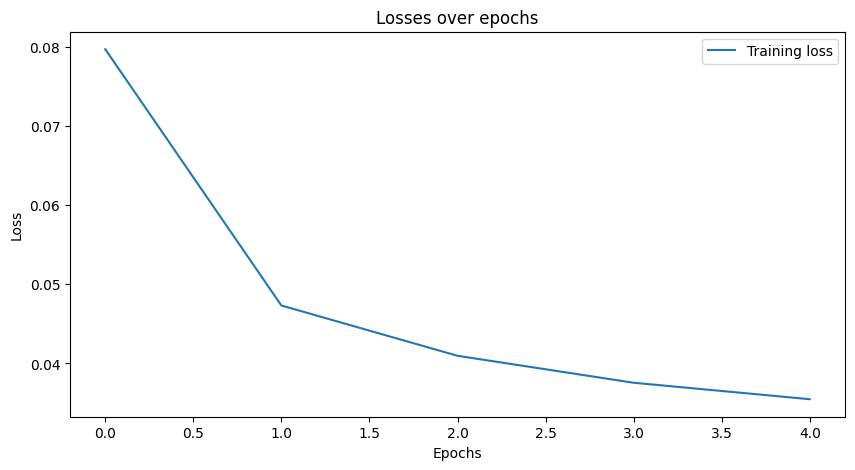

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.title('Losses over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# AlexNet Testing Implementation

This code is used to test AlexNet against the imported dataset and get the accuracy

In [16]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 227, 227])
Labels batch shape: torch.Size([32])


### Make the model go to eval mode

In [17]:
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
correct_count, all_count = 0, 0
tn, fp, fn, tp = 0, 0, 0, 0
print("Please wait while all images are being tested.....")
for images,labels in test_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 3, 227, 227).to(device)
    with torch.no_grad():
        logps = alexnet(img)

    ps = torch.exp(logps).cpu().data
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
        correct_count += 1
        if true_label == 1:
            tp += 1  # True positive: correctly predicted as class 1
        else:
            tn += 1  # True negative: correctly predicted as class 0
    else:
        if true_label == 1:
            fn += 1  # False negative: incorrectly predicted as class 0
        else:
            fp += 1  # False positive: incorrectly predicted as class 1

    all_count += 1

print("Number Of Images Tested =", all_count)
print("Number Of Correct Images", correct_count)
print("Number of Incorrect Images", all_count - correct_count)
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print("\nModel Accuracy =", (correct_count/all_count))

Please wait while all images are being tested.....
Number Of Images Tested = 125157
Number Of Correct Images 123643
Number of Incorrect Images 1514
True Positives: 116927
True Negatives: 6716
False Positives: 1322
False Negatives: 192

Model Accuracy = 0.9879031935888524


### Confusion Matrix

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


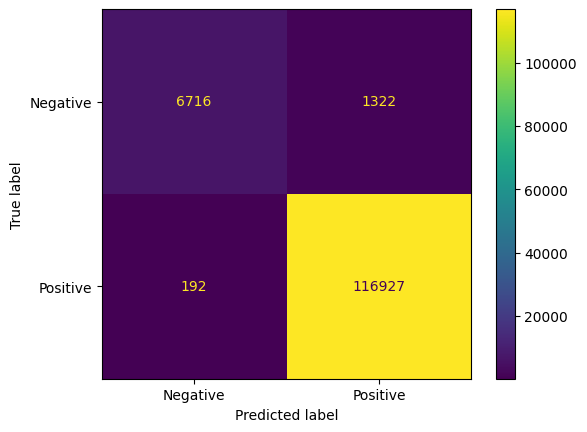

In [5]:
# Create the confusion matrix
cm = np.array([[tn, fp],
               [fn, tp]])

# Create a confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

# Plot the confusion matrix
disp.plot(cmap='viridis')
plt.show()

In [8]:
# Assuming precision, recall, f1_score, and accuracy are already defined
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print(f"Precision: {precision}")
print(f"recall: {recall}")
print(f"f1_score: {f1_score}")
print(f"accuracy: {accuracy}")

Precision: 0.9888202014393357
recall: 0.998360641740452
f1_score: 0.9935675197987831
accuracy: 0.9879031935888524


### Save the model

In [11]:
# Only Saves the model image, The model needs to rebuild before using 
torch.save(alexnet.state_dict(), f'alexnet_e{num_epochs}.pth')

In [19]:
#Save entire model
torch.save(alexnet, f'complete_alexnet_e{num_epochs}.pt')